In [ ]:
import pandas as pd
train_data = pd.read_excel('/content/drive/MyDrive/SPH 6004/Assignment 2/Version 3/Timestep5_train.xlsx')
test_data = pd.read_excel('/content/drive/MyDrive/SPH 6004/Assignment 2/Version 3/Timestep5_test.xlsx')
holdout_data = pd.read_excel('/content/drive/MyDrive/SPH 6004/Assignment 2/Version 3/Timestep5_holdout.xlsx')

In [ ]:
train_data.info()

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def create_sequences_fixed(data, timestep):
    numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()
    columns_to_scale = [col for col in numeric_columns if col not in ['id', 'charttime', 'los_icu', 'icu_death', 'hour', 'icu_cat']]

    grouped_data = data.groupby('id')
    scaler = MinMaxScaler()

    time_series = []
    targets = []

    for _, group_data in grouped_data:

        scaled_data = scaler.fit_transform(group_data[columns_to_scale])

        target_data = group_data['los_icu'].iloc[-1]

        time_series.append(scaled_data)
        targets.append(target_data)
    return np.array(time_series), np.array(targets)

In [ ]:
timestep = 5
train_sequences, train_targets = create_sequences_fixed(train_data, timestep)
test_sequences, test_targets = create_sequences_fixed(test_data, timestep)
holdout_sequences, holdout_targets = create_sequences_fixed(holdout_data, timestep)

In [ ]:
train_sequences.shape, train_targets.shape

((14289, 5, 59), (14289,))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D

model = Sequential([
    Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(timestep, train_sequences.shape[2])),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=2, activation='relu'),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 32)             3808      
                                                                 
 max_pooling1d (MaxPooling1  (None, 2, 32)             0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             4160      
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 50)                3250      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                        

In [ ]:
print(model.layers[0].input_shape)

(None, 5, 59)


In [ ]:
history = model.fit(train_sequences, train_targets, epochs=10, validation_data = (holdout_sequences, holdout_targets))

Epoch 1/10
447/447 [==============================] - 3s 5ms/step - loss: 37.4629 - mae: 3.5657 - val_loss: 30.1734 - val_mae: 3.6853
Epoch 2/10
447/447 [==============================] - 2s 5ms/step - loss: 36.3681 - mae: 3.5483 - val_loss: 30.3675 - val_mae: 3.0483
Epoch 3/10
447/447 [==============================] - 1s 3ms/step - loss: 36.1717 - mae: 3.5350 - val_loss: 29.6569 - val_mae: 3.4836
Epoch 4/10
447/447 [==============================] - 1s 3ms/step - loss: 35.9236 - mae: 3.5337 - val_loss: 29.8809 - val_mae: 3.1586
Epoch 5/10
447/447 [==============================] - 1s 3ms/step - loss: 35.6728 - mae: 3.5188 - val_loss: 29.5382 - val_mae: 3.4186
Epoch 6/10
447/447 [==============================] - 1s 3ms/step - loss: 35.6039 - mae: 3.5137 - val_loss: 29.7300 - val_mae: 3.1979
Epoch 7/10
447/447 [==============================] - 1s 3ms/step - loss: 35.4848 - mae: 3.5056 - val_loss: 29.7496 - val_mae: 3.2016
Epoch 8/10
447/447 [==============================] - 1s 3ms/s

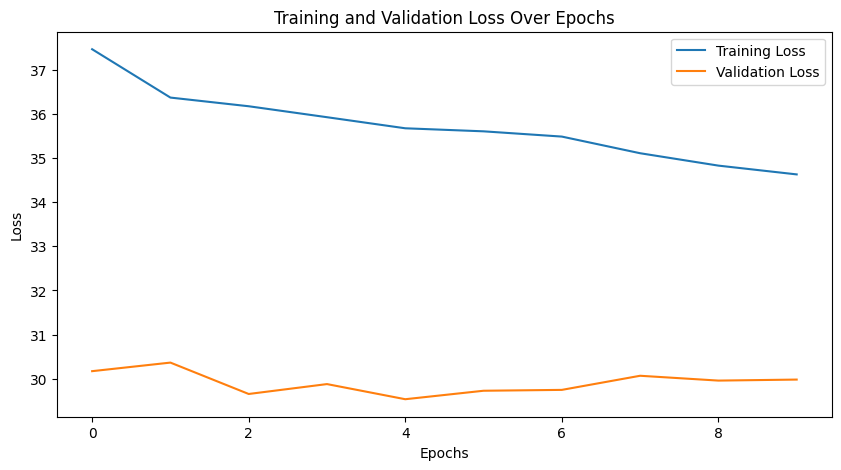

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_sequences, test_targets)

128/128 [==============================] - 0s 2ms/step - loss: 35.2480 - mae: 3.7352


[35.247982025146484, 3.735158920288086]

In [ ]:
test_predict = model.predict(test_sequences)
test_predict = np.round(test_predict, 2)

128/128 [==============================] - 0s 3ms/step


In [ ]:
test_predict

array([[4.25],
       [5.28],
       [5.6 ],
       ...,
       [6.6 ],
       [5.02],
       [6.12]], dtype=float32)

In [ ]:
test_targets

array([2.87, 3.32, 2.42, ..., 2.37, 5.12, 1.2 ])